# Vsebina projektne naloge
Cilj projektne naloge je uporabiti in dodatno nadgraditi znanja, ki ste jih osvojili tekom izdelave sprotnih nalog. V sklopu projektne naloge se boste spoprijeli z izzivom regresijskega problema, natančneje z napovedovanjem časovnih vrst. V tem primeru bo šlo za realne meritve kvalitete zraka, vaš cilj pa bo čim natančneje napovedati vrednost parametra pm10.

In [220]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from scipy.stats import boxcox
from matplotlib import pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor

In [221]:
df = pd.read_csv('data/RV1_SIPIA.csv')

In [222]:
df.head(10)

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10
0,2023-06-23 08:35:00+00:00,46.234818,15.267305,240.0,52.0,40.0,16.0,148.0
1,2023-09-17 07:35:00+00:00,46.234818,15.267305,240.0,11.0,118.0,7.0,135.0
2,2023-02-16 18:15:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
3,2023-02-16 18:35:00+00:00,46.234818,15.267305,240.0,88.0,74.0,1.0,132.0
4,2023-02-16 20:35:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
5,2023-02-16 20:15:00+00:00,46.234818,15.267305,240.0,70.0,102.0,2.0,128.0
6,2023-02-16 23:35:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
7,2023-02-16 23:15:00+00:00,46.234818,15.267305,240.0,47.0,111.0,2.0,118.0
8,2023-02-16 21:15:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0
9,2023-02-16 21:35:00+00:00,46.234818,15.267305,240.0,68.0,102.0,2.0,116.0


In [223]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=["Date"], inplace=True)

In [224]:
def plot_values(x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x], df[y])
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

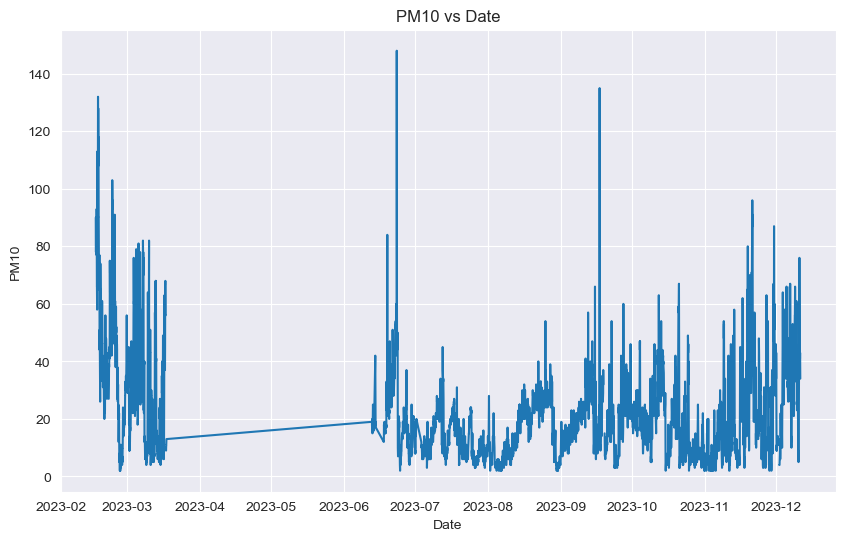

In [225]:
plot_values('Date', 'PM10')

In [226]:
# remove data before 2023-06
#df = df[df['Date'] >= '2023-06-01']
# DONT do this

In [227]:
# remove outliers 
# colud be a good idea
#df = df[df['PM10'] < 120]

In [228]:
# does not really help
# mean = df['PM10'].mean()
# std = df['PM10'].std()
# 
# z_score = (df['PM10'] - mean) / std
# threshold = 3
# 
# df = df[z_score < threshold]

# Vnos vremenskih podatkov
Dodamo vremenske podatke za te to lokacijo v tem času, ker bi nam mogoče lahko prišlo prav.

In [229]:
df_weather = pd.read_csv('data/weather.csv')
df_weather.head()

,Date,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-01-01 00:15:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
1,2023-01-01 00:35:00+00:00,7.7,85.0,5.3,5.5,0.0,0.0,0.0,992.7,7.0,6.7,144.0,2.6,0.357,0.0
2,2023-01-01 01:15:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
3,2023-01-01 01:35:00+00:00,7.8,84.0,5.2,5.7,0.0,0.0,0.0,992.8,4.0,6.4,133.0,2.1,0.356,0.0
4,2023-01-01 02:15:00+00:00,4.8,92.0,3.6,1.9,0.0,0.0,0.0,992.5,10.0,9.2,141.0,1.8,0.356,0.0


In [230]:
df_weather['Date'] = pd.to_datetime(df_weather['Date'], utc=True)

In [231]:
df.isnull().sum()

Date           0
Latitude       0
Longitude      0
Altitude       0
NO2          402
PM2.5         67
O3           297
PM10          67
dtype: int64

In [232]:
df = pd.merge(df, df_weather, on='Date', how='left')
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,precipitation (mm),rain (mm),snowfall (cm),surface_pressure (hPa),cloud_cover (%),wind_speed_10m (km/h),wind_direction_10m (°),soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day ()
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,NaN,90.0,0.5,91.0,...,0.0,0.0,0.0,996.8,0.0,8.0,190.0,0.4,0.348,0.0
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.0,86.0,0.1,92.0,...,0.0,0.0,0.0,996.8,0.0,5.9,227.0,0.2,0.348,0.0
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.0,78.0,-1.1,93.0,...,0.0,0.0,0.0,996.6,0.0,4.6,252.0,0.1,0.348,0.0


# Dodajanje novih značilnic
Z namenom izboljšanja napovedi dodamo nove značilnice, ki bi lahko vplivale na kvaliteto zraka.

In [233]:
df["PM2.5/N02"] = df["PM2.5"] / df["NO2"]

df["PM2.5/03"] = df["PM2.5"] / df["O3"]

df['Season'] = df['Date'].dt.month.apply(lambda x: 'Winter' if (x == 12 or x <= 2) else
('Spring' if (3 <= x <= 5) else
 ('Summer' if (6 <= x <= 8) else
  ('Autumn' if (9 <= x <= 11) else None))))

df["Season"].astype('category')

df["Weekend"] = df["Date"].dt.dayofweek.apply(lambda x: 1 if (x == 5 or x == 6) else 0)

Kodiranje kategoričnih spremenljivk

In [234]:
df = pd.get_dummies(df, columns=['Season'])

In [235]:
df.isnull().sum()

Date                                0
Latitude                            0
Longitude                           0
Altitude                            0
NO2                               402
PM2.5                              67
O3                                297
PM10                               67
temperature_2m (°C)                 1
relative_humidity_2m (%)            1
dew_point_2m (°C)                   1
apparent_temperature (°C)           1
precipitation (mm)                  1
rain (mm)                           1
snowfall (cm)                       1
surface_pressure (hPa)              1
cloud_cover (%)                     1
wind_speed_10m (km/h)               1
wind_direction_10m (°)              1
soil_temperature_0_to_7cm (°C)      1
soil_moisture_0_to_7cm (m³/m³)      1
is_day ()                           1
PM2.5/N02                         403
PM2.5/03                          297
Weekend                             0
Season_Autumn                       0
Season_Sprin

Odstranimo vrstice kjer je PM10 null

In [236]:
# remove rows where PM10 is null
df = df[df['PM10'].notnull()]

# Zapolnimo manjkajoče vrednosti
Manjkajoče vrednosti zapolnimo z vrednostmi, ki jih napovemo s pomočjo modela.

In [237]:
cols_to_fill = df.columns[df.isnull().any()].tolist()

In [238]:
for col in cols_to_fill:
    incomplete_rows = df[df[col].isnull()]
    complete_rows = df[~df[col].isnull()]

    # Features and target columns excluding 'Date'
    features = [c for c in df.columns if c != col and c != 'Date']
    target = col

    X_train = complete_rows[features]
    y_train = complete_rows[target]

    model = HistGradientBoostingRegressor()

    model.fit(X_train, y_train)

    predicted_values = model.predict(incomplete_rows[features])

    df.loc[df[col].isnull(), col] = predicted_values

In [239]:
df.isnull().sum()

Date                              0
Latitude                          0
Longitude                         0
Altitude                          0
NO2                               0
PM2.5                             0
O3                                0
PM10                              0
temperature_2m (°C)               0
relative_humidity_2m (%)          0
dew_point_2m (°C)                 0
apparent_temperature (°C)         0
precipitation (mm)                0
rain (mm)                         0
snowfall (cm)                     0
surface_pressure (hPa)            0
cloud_cover (%)                   0
wind_speed_10m (km/h)             0
wind_direction_10m (°)            0
soil_temperature_0_to_7cm (°C)    0
soil_moisture_0_to_7cm (m³/m³)    0
is_day ()                         0
PM2.5/N02                         0
PM2.5/03                          0
Weekend                           0
Season_Autumn                     0
Season_Spring                     0
Season_Summer               

In [240]:
df.head()

,Date,Latitude,Longitude,Altitude,NO2,PM2.5,O3,PM10,temperature_2m (°C),relative_humidity_2m (%),...,soil_temperature_0_to_7cm (°C),soil_moisture_0_to_7cm (m³/m³),is_day (),PM2.5/N02,PM2.5/03,Weekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,2023-02-15 19:35:00+00:00,46.234818,15.267305,240.0,70.0,71.0,103.240981,90.0,0.5,91.0,...,0.4,0.348,0.0,1.014286,0.264237,0,False,False,False,True
1,2023-02-15 20:15:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
2,2023-02-15 20:35:00+00:00,46.234818,15.267305,240.0,56.0,76.0,2.000000,86.0,0.1,92.0,...,0.2,0.348,0.0,1.357143,38.000000,0,False,False,False,True
3,2023-02-15 21:15:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True
4,2023-02-15 21:35:00+00:00,46.234818,15.267305,240.0,48.0,73.0,2.000000,78.0,-1.1,93.0,...,0.1,0.348,0.0,1.520833,36.500000,0,False,False,False,True


In [241]:
np.any(np.isnan(df))

False

# Odkrivanje odvisnosti med spremenljivkam in ciljno spremenljivko

In [242]:
output_col = 'PM10'

input_cols = df.columns.tolist()
input_cols.remove(output_col)
input_cols.remove('Date')

information_gain_scores = mutual_info_regression(df[input_cols], df[output_col])

feature_importances = pd.Series(information_gain_scores, index=input_cols)
feature_importances.name = 'Information Gain Scores'
feature_importances.sort_values(ascending=False, inplace=True)

feature_importances.head(10)

PM2.5                             1.485501
PM2.5/03                          0.785615
PM2.5/N02                         0.562566
soil_moisture_0_to_7cm (m³/m³)    0.488678
dew_point_2m (°C)                 0.387584
soil_temperature_0_to_7cm (°C)    0.370328
NO2                               0.342424
apparent_temperature (°C)         0.325969
temperature_2m (°C)               0.311425
O3                                0.306842
Name: Information Gain Scores, dtype: float64

<Axes: >

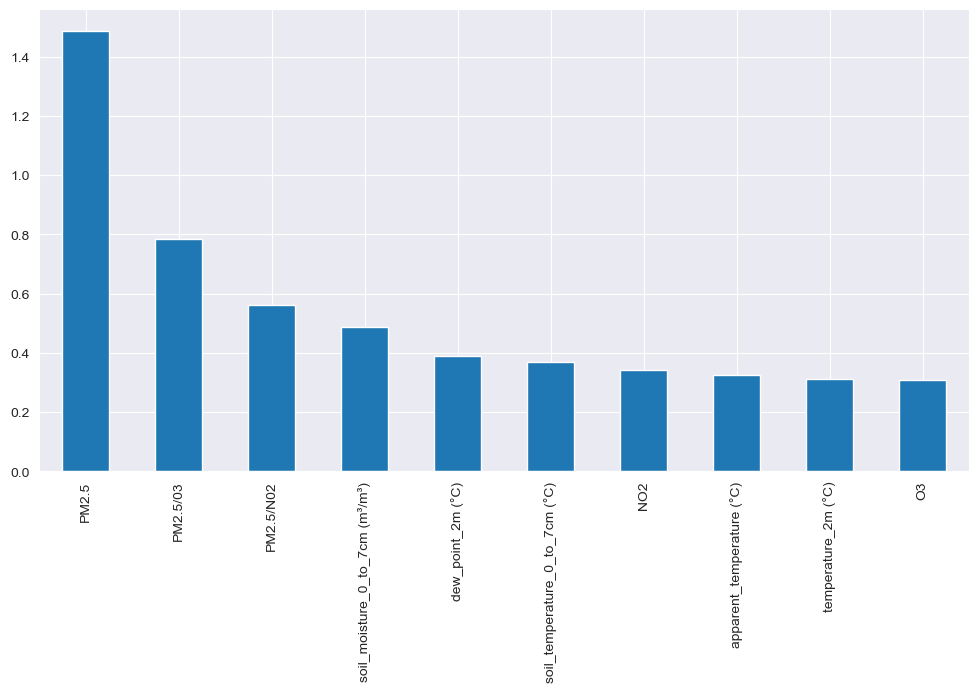

In [243]:
feature_importances.head(10).plot.bar(figsize=(12, 6))

In [244]:
top_features = feature_importances.head(3).index.tolist()
print(top_features)

['PM2.5', 'PM2.5/03', 'PM2.5/N02']


# Odpravljanje izkrivljenosti podatkov
- Box-Cox transformacija


In [245]:
def boxcox_transform(column):
    # create before and after plots for comparison
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.distplot(df[column], ax=ax[0])
    ax[0].set_title("Before Box-Cox")

    # transform data
    data = boxcox(df[column], lmbda=0.0)

    # create after plots
    sns.distplot(data, ax=ax[1])
    ax[1].set_title("After Box-Cox")

    # update dataframe
    df[column] = data

    plt.show()

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

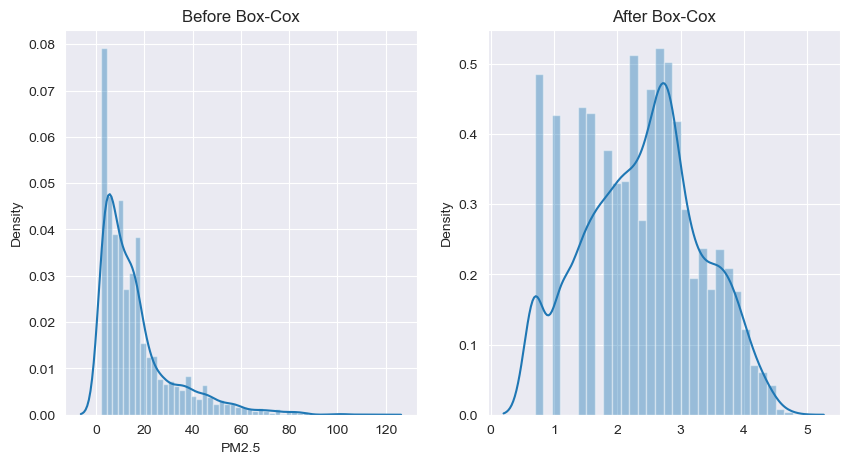

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

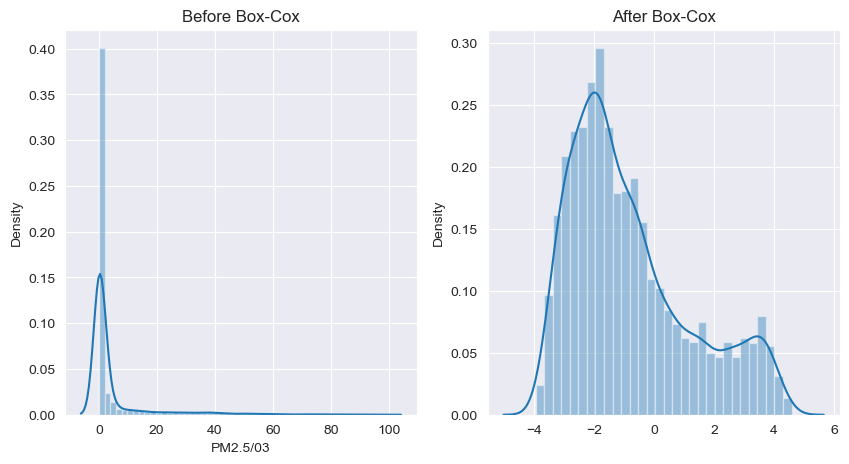

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column], ax=ax[0])
/opt/homebrew/Caskroom/miniforge/base/envs/rnn/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/2837000130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to 

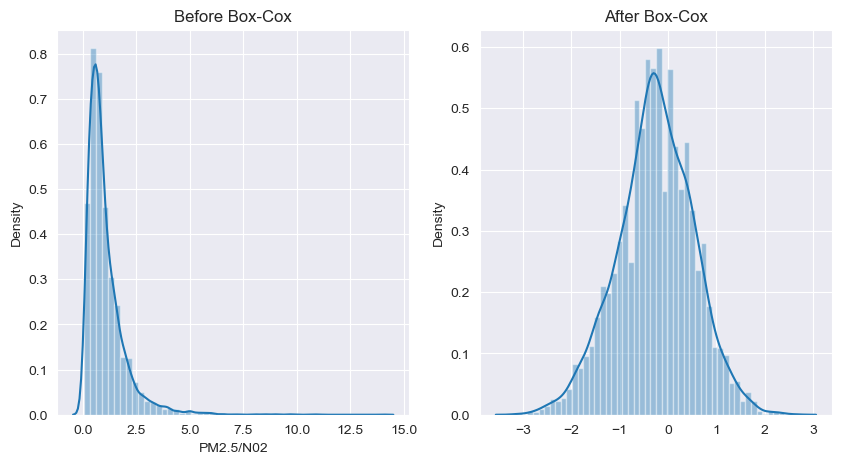

In [246]:
for feature in top_features:
    boxcox_transform(feature)

# Priprava podatkov za modeliranje

In [247]:
target = "PM10"
features = [target] + top_features
dataset = df[features]

In [248]:
dataset.shape

(5558, 4)

In [249]:
test_split = round(len(dataset) * 0.2)

In [250]:
train_data = dataset[:-test_split]
test_data = dataset[-test_split:]

In [251]:
print(train_data.shape, test_data.shape)

(4446, 4) (1112, 4)


## Normalizacija podatkov

In [252]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Ustvarjanje vhodno-izhodnih parov
Za napovedovanje časovnih vrst bomo uporabili vhodno-izhodne pare, kjer bo vhod predstavljal n preteklih vrednosti, izhod pa bo predstavljal trenutno vrednost.

In [253]:
def create_multivariate_time_series(data, n_past, target_col=0, feature_cols=None):
    if feature_cols is None:
        feature_cols = list(range(data.shape[1]))

    X, y = [], []
    for i in range(n_past, len(data)):
        X.append(data[i - n_past:i, feature_cols])
        y.append(data[i, target_col])

    return np.array(X), np.array(y)

In [254]:
# Usage of create_multivariate_time_series function
num_of_days = 1
num_of_measurements_per_day = 48
n_past = num_of_measurements_per_day * num_of_days  # Number of past time steps to consider
target_col = 0  # Index of the target column (PM10) in your dataset
feature_cols = list(range(len(features)))  # All columns used as features

In [255]:
# Creating input-output pairs using the function
X_train, y_train = create_multivariate_time_series(train_data, n_past, target_col, feature_cols)
X_test, y_test = create_multivariate_time_series(test_data, n_past, target_col, feature_cols)

In [256]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

In [257]:
print(f"Shape of training data: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of testing data: X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of training data: X_train: (4398, 48, 4), y_train: (4398,)
Shape of testing data: X_test: (1064, 48, 4), y_test: (1064,)


In [258]:
print(X_test.shape, y_test.shape)

(1064, 48, 4) (1064,)


# Ustvarjanje modelov
Ustvarili bomo več različnih modelov in izbrali najboljšega.

In [259]:
# {'units': 32, 'optimizer': 'rmsprop', 'epochs': 50, 'dropout_rate': 0.4, 'batch_size': 128, 'activation': 'tanh'}
# units = 32
# optimizer = 'rmsprop'
# dropout_rate = 0.4
# activation = 'tanh'
# batch_size = 128
# epochs = 100

In [260]:
param_grid = {
    'units': [32, 64, 128],
    #'optimizer': ['adam', 'rmsprop', 'SGD', "Adagrad"],
    'optimizer': ['adam', 'rmsprop'],
   # 'activation': ['relu', 'sigmoid', 'tanh', "softmax"],
    'activation': ['swish', 'softmax', 'tanh'],
    'batch_size': [32, 64, 128],
    'epochs': [10, 25, 50],
    'dropout_rate': [0.2, 0.3, 0.4],
}

In [261]:
def build_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_layer_1=0.2,
               dropout_rate=0.2):
    model = Sequential(name="LSTM")

    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=units))

    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [262]:
def build_gru(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="GRU")

    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    model.add(GRU(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(GRU(units=units))

    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [263]:
def build_conv_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    # Define the CNN-LSTM model
    model = Sequential(name="Conv_LSTM")

    # Convolutional layers for feature extraction
    model.add(
        Conv1D(filters=64, kernel_size=3, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layers for sequence modeling
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=units))

    # Output layer
    model.add(Dense(units=1))  # Adjust units for your specific output

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [264]:
def build_advance_conv_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    # Define the CNN-LSTM model
    model = Sequential(name="Advance_Conv_LSTM")

    # Convolutional layers for feature extraction
    model.add(
        Conv1D(filters=64, kernel_size=3, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation=activation))
    model.add(MaxPooling1D(pool_size=2))

    # LSTM layers for sequence modeling
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dense(units=32, activation=activation))

    # Output layer
    model.add(Dense(units=1))  # Adjust units for your specific output

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

In [265]:
def build_advance_gru(units=0,optimizer='adam', activation='relu', dropout_rate=0.2):
    model = Sequential(name="GRU")

    model.add(GRU(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    model.add(GRU(units=64, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(GRU(units=32))
    
    model.add(Dense(units=32, activation=activation))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [266]:

def build_advance_lstm(units=32, optimizer='adam', activation='relu', batch_size=32, epochs=10, dropout_rate=0.2):
    model = Sequential(name="Advance_LSTM")

    model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units=32))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [267]:
model_fns = [build_gru, build_advance_gru]
#model_fns = [build_advance_gru,build_advance_lstm]

model_names = ['GRU', 'Advanced_GRU']
#model_names = ["GRU"]

In [268]:
best_score = float('-inf')
best_model = None
best_grid_result = None
history = {}
best_models = {}

for idx, create_model_fn in enumerate(model_fns):

    model = KerasRegressor(build_fn=create_model_fn, verbose=0)

    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              scoring='neg_mean_squared_error', cv=3, n_iter=3,
                              random_state=1234)

    grid_result = grid.fit(X_train, y_train, verbose=1, validation_data=(X_test, y_test))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    history[model_names[idx]] = grid_result.best_estimator_.model.history.history
    best_models[model_names[idx]] = grid_result.best_estimator_.model

    if grid_result.best_score_ > best_score:
        best_score = grid_result.best_score_
        best_model = grid_result.best_estimator_.model
        best_grid_result = grid_result

print("Best model found:", best_model.name)
print("Best score:", best_score)

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/3251881518.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/50
23/23 [==============================] - 3s 51ms/step - loss: 0.0055 - val_loss: 0.0150
Epoch 2/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0047 - val_loss: 0.0143
Epoch 3/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0045 - val_loss: 0.0133
Epoch 4/50
23/23 [==============================] - 1s 34ms/step - loss: 0.0042 - val_loss: 0.0120
Epoch 5/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0037 - val_loss: 0.0108
Epoch 6/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0032 - val_loss: 0.0090
Epoch 7/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 8/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0026 - val_loss: 0.0079
Epoch 9/50
23/23 [==============================] - 1s 39ms/step - loss: 0.0026 - val_loss: 0.0078
Epoch 10/50
23/23 [==============================] - 1s 40ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 11/

/var/folders/m7/dkyjm7gn71ggjt2b8p3ymthc0000gn/T/ipykernel_7614/3251881518.py:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model_fn, verbose=0)


Epoch 1/50
23/23 [==============================] - 5s 112ms/step - loss: 0.0053 - val_loss: 0.0160
Epoch 2/50
23/23 [==============================] - 2s 99ms/step - loss: 0.0050 - val_loss: 0.0153
Epoch 3/50
23/23 [==============================] - 2s 99ms/step - loss: 0.0049 - val_loss: 0.0147
Epoch 4/50
23/23 [==============================] - 2s 100ms/step - loss: 0.0046 - val_loss: 0.0137
Epoch 5/50
23/23 [==============================] - 2s 102ms/step - loss: 0.0043 - val_loss: 0.0124
Epoch 6/50
23/23 [==============================] - 2s 104ms/step - loss: 0.0037 - val_loss: 0.0104
Epoch 7/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0031 - val_loss: 0.0087
Epoch 8/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 9/50
23/23 [==============================] - 2s 103ms/step - loss: 0.0025 - val_loss: 0.0079
Epoch 10/50
23/23 [==============================] - 2s 105ms/step - loss: 0.0025 - val_loss: 0.0077
E

# Vizualizacija rezultatov in ovrednotenje modelov

In [269]:
def plot_history(history):
    plt.figure(figsize=(12, 8))
    for name, values in history.items():
        plt.plot(values['loss'], label=name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.show()

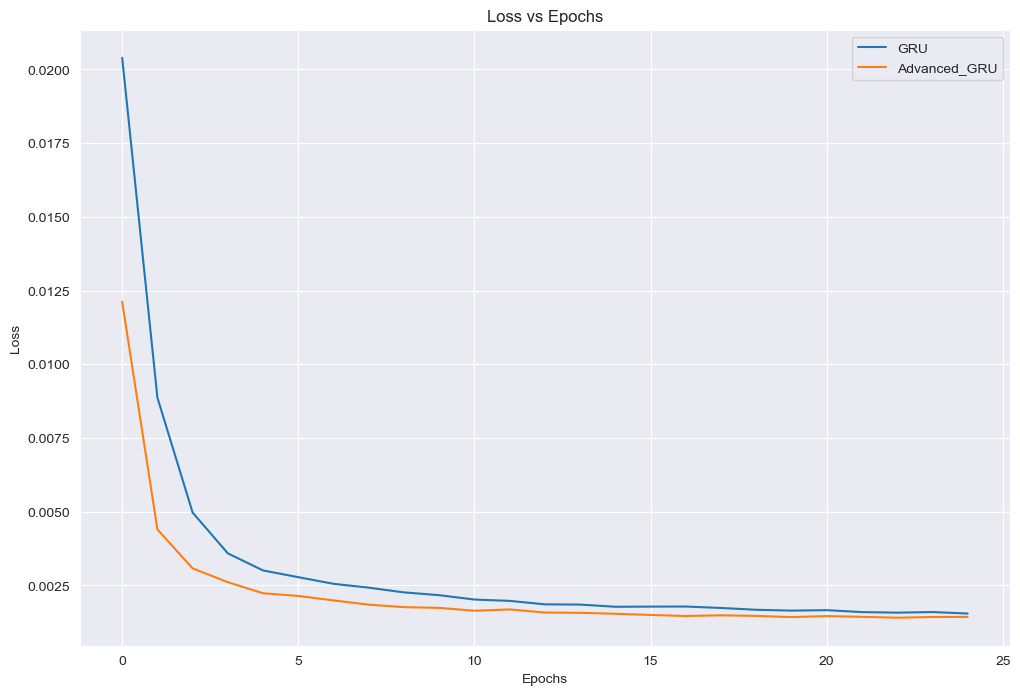

In [270]:
plot_history(history)

In [271]:
y_test_copies = np.repeat(y_test, dataset.shape[1], axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copies, (len(y_test), dataset.shape[1])))[:, 0]

In [272]:
results = {
    'MAE': [],
    'MSE': [],
    'EVS': []
}

for model in best_models.values():
    predicted = model.predict(X_test)

    prediction_copies = np.repeat(predicted, dataset.shape[1], axis=-1)
    predicted = scaler.inverse_transform(np.reshape(prediction_copies, (len(predicted), dataset.shape[1])))[:, 0]

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)

    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)

34/34 [==============================] - 0s 4ms/step
GRU - MSE: 39.62
GRU - MAE: 4.39
GRU - EVS: 0.88
--------------------
34/34 [==============================] - 1s 9ms/step
GRU - MSE: 36.87
GRU - MAE: 4.01
GRU - EVS: 0.88
--------------------


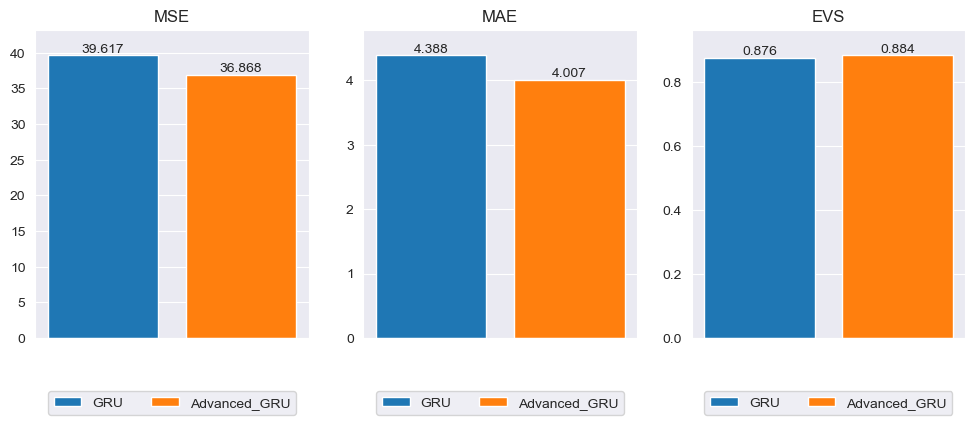

In [273]:
metrics = ['MSE', 'MAE', 'EVS']

width = 0.8
cols = len(metrics)

fig, axs = plt.subplots(1, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')

    for j, model in enumerate(model_names):
        value = results[metric][j][1]
        if value > max:
            max = value
        ax.bar(j, value, width, label=model)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')

    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [274]:
#model = build_conv_lstm()

In [275]:
# history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1,
#                     shuffle=False)

In [276]:
prediction = best_model.predict(X_test)

34/34 [==============================] - 0s 9ms/step


In [277]:
prediction.shape

(1064, 1)

In [278]:
y_test.shape

(1064,)

In [279]:
prediction_copies_array = np.repeat(prediction, dataset.shape[1], axis=-1)

In [280]:
prediction_copies_array.shape

(1064, 4)

In [281]:
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(prediction), dataset.shape[1])))[:, 0]

In [282]:
pred.shape

(1064,)

In [283]:
pred

array([ 3.8253903,  4.1286182,  4.2188153, ..., 40.422752 , 42.185097 ,
       37.320786 ], dtype=float32)

In [284]:
# mse,mea, evs
# mse = mean_squared_error(y_test, prediction)
# mae = mean_absolute_error(y_test, prediction)
# evs = explained_variance_score(y_test, prediction)
# 
# print(f"Mean Squared Error: {mse}")
# print(f"Mean Absolute Error: {mae}")
# print(f"Explained Variance Score: {evs}")

In [285]:
dates = df['Date'].values

In [286]:
df_output = pd.DataFrame({"Date":
                              dates[-test_split + n_past:], 'Actual': y_test, 'Predicted': pred})
df_output.head(100)

,Date,Actual,Predicted
0,2023-10-27 15:35:00,3.0,3.825390
1,2023-10-27 16:35:00,4.0,4.128618
2,2023-10-27 17:35:00,4.0,4.218815
3,2023-10-27 18:35:00,8.0,5.413738
4,2023-10-27 19:35:00,12.0,9.176561
...,...,...,...
95,2023-10-31 14:35:00,4.0,2.612161
96,2023-10-31 15:35:00,4.0,3.009335
97,2023-10-31 16:35:00,2.0,3.838159
98,2023-10-31 17:35:00,3.0,3.624589


In [287]:
def plot_results():
    plt.figure(figsize=(12, 8))
    plt.plot(df_output['Date'], df_output["Actual"], label='Actual')
    plt.plot(df_output['Date'], df_output['Predicted'], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('PM10')
    plt.title('PM10 vs Time')
    plt.legend()
    plt.show()

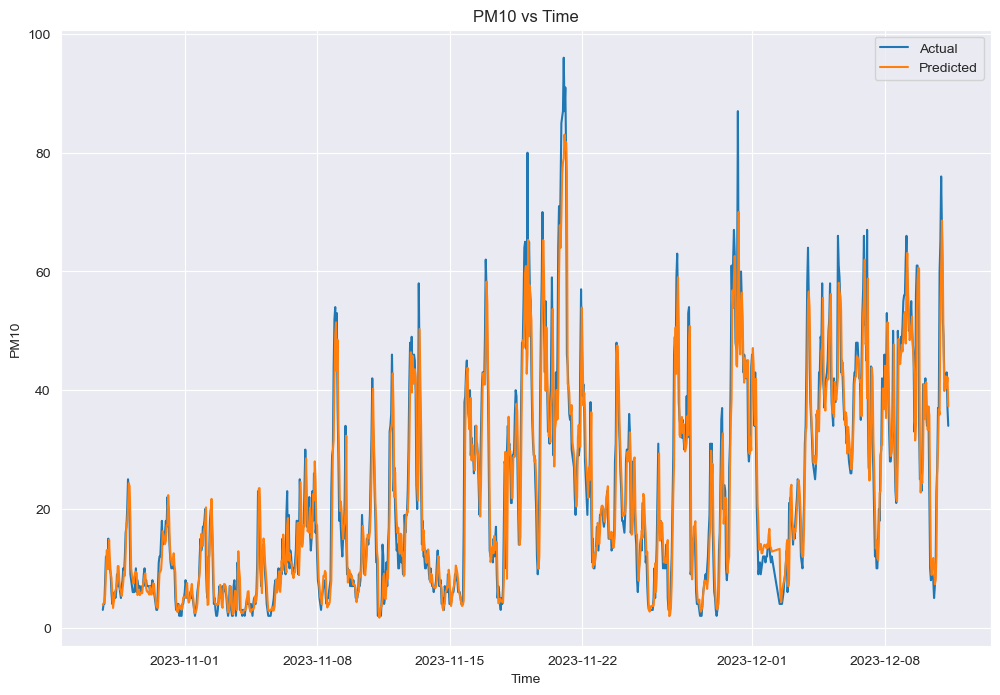

In [288]:
plot_results()

# Shranjevanje modela in normalizacijskega faktorja

In [289]:
mse = mean_squared_error(y_test, pred)
mse = format(mse, ".2f")
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 36.87


In [290]:
model_name = best_model.name

In [291]:
selected_features = ['PM10'] + top_features
num_of_features = len(selected_features)

In [292]:
best_model.save(f'out/model_{model_name}_features_{num_of_features}_mse_{mse}.h5')

In [293]:
with open(f'out/scaler_model_{model_name}_features_{num_of_features}_mse_{mse}.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Izvoz podatkov za API

In [294]:
dataset.to_json('out/data.json', orient='records')